# CW2 - Coding Part 2 (30 points)
# Variational Autoencoders
Build a Convolutional Variational AutoEncoder and achieve best possible reconstruction and latent space disentanglement. Then answer the questions.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchsummary import summary

import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

In [ ]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [ ]:
# Load the data

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

#                 ** MODIFY CODE HERE IF NECESSARY **

batch_size = 100

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

def denormalize(x):
    return x

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

# Download test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
)

torch.Size([3, 122, 242])
torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])


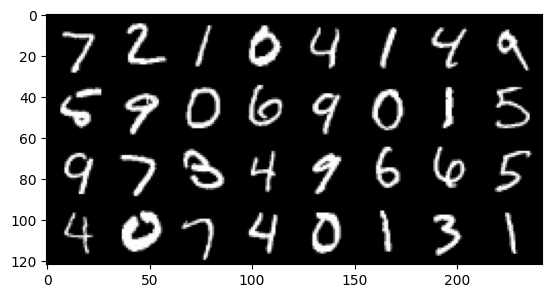

In [ ]:
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)
print(img.shape)
print(sample_inputs.shape)
print(sample_inputs.shape[1:])

# Variational Auto Encoders (VAEs)

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">2</a>.
  </figcaption>
</figure>

## Build a convolutional VAE (5 points)

The only requirement is that it contains convolutions both in the encoder and decoder. You can still use some linear layers if needed.

In [ ]:
import torch.nn.functional as F
# Convolutional VAE implementation here
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.latent_dim = latent_dim

        #layers for encoder
        self.input = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.mean = nn.Linear(64 *4 *4, self.latent_dim)
        self.std = nn.Linear(64 *4 *4, self.latent_dim)

        self.dfc = nn.Linear(latent_dim,64 * 7 * 7)

        #layers for decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=2, stride=2, padding=1),
            nn.Sigmoid()
            )

        #self.output = nn.Linear(16, 784)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        out = self.input(x)
        out = self.flatten(out)
        mu = self.mean(out)

        #encode the logarigthm of the variance
        logvar = self.std(out)

        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn(std.size()).to(device)
        return mu + std * epsilon

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.dfc(z)
        out = out.view(out.size(0), 64, 7, 7)
        out = self.decoder(out)

        return out



        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        ####################################################################### NEEDS CONV LAYER

        #encode, reparametrize, decode
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return mu, logvar, self.decode(z)

        ####################################################################### NOT DONEEEE
        #                       ** END OF YOUR CODE **
        ####################################################################### NOT DONEE NEEDS CONV LAYER

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

latent_dim = 16

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

model = VAE(latent_dim).to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              ReLU-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 16]          16,400
            Linear-9                   [-1, 16]          16,400
           Linear-10                 [-1, 3136]          53,312
  ConvTranspose2d-11           [-1, 64, 14, 14]          36,928
             ReLU-12           [-1, 64, 14, 14]               0
  ConvTranspose2d-13           [-1, 32, 28, 28]          18,464
             ReLU-14           [-1, 32,

Briefly Explain your architectural choices

<font color='red'>The VAE consists of an encoder, a decoder, and 3 fully connected linear layers. Two of the linear layers are used for the mean and standard deviation. The last linear layer is used so the outputs from the mean and standard deviation layers can be passed to the decoder convolutional layers, and help capture more global features in the feature map.

The encoder consists of convolutional layers with increasing channel size to allow the model to capture more complex data, while the ReLU activation introduces non-linearity to the model.

The decoder consists of 2D transpose layers which upsample and reconstruct the input. An extra transpose layer is added to account for the final Conv2D layer used in the decoder.

The final layer of the decoder is a Conv2D layer. This is used for recreation of the images, along with the final Sigmoid activation function which ensures the output values are between the 0 and 1 range.</font>

## Defining a Loss (6 points)

The Beta VAE loss, with encoder $q$ and decoder $p$:
$$ L=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

The loss you implement depends on your choice of latent prior and model outputs.

There exist different solutions that are equally correct. Depending on your assumptions you might want to do a data preprocessing step.



In [ ]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        MSE_loss = torch.pow(recon_x - x, 2).sum()
        KL_divergence = 0.5 * torch.sum(1+logvar - mu**2 - torch.exp(logvar))

        return MSE_loss - beta * KL_divergence, MSE_loss, KL_divergence

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

Briefly answer the following:

a.   Explain what are the possible choices of reconstruction loss, and which one you choose. Explain how it relates to

1.   Your choice of VAE prior
2.   The output data domain
3.   The latent space disentanglement

Feel free to try and train with different reconstruction losses to see which one works best

<font color='red'>***YOUR ANSWER***</font>

a. The choices for reconstruction loss are Mean Squared Error,or Binary Cross Entropy. As MNIST data can have values between 0 and 1 and are not binary, I chose MSE as the reconstruction loss.

1. As I am assuming a Gaussian prior, MSE is compatible as it assumes a Gaussian distribution
2.   As the output data is continuous values ranging between 0 and 1, MSE works well with the output data domain.
3. MSE influences the latent space, but does not enforce disentanglement.



## Train and plot

Train the VAE and plot:

1.   The total loss curves for train and test (on the same plot)
2.   The reconstruction losses for train and test (on the same plot)
3.   The KL losses for train and test (on the same plot)

(x-axis: epochs, y-axis: loss)

You may want to have different plots with differente values of $\beta$.

Hint: You can modify the training scripts provided in previous tutorials to record the required information, and use matplotlib to plot them
Hint: If you plan on doing hyperparameter tuning, it might be a good idea to split the training set and create a validation set

In [ ]:
# Training code

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

def train(dataloader, model, loss_fn, optimizer, beta):
  size = len(dataloader.dataset)
  model.train()
  total_loss, reconstruction_loss, KL_loss = 0, 0, 0

  for batch, (x, _) in enumerate(dataloader):
    #x = x.reshape(-1, 1, 28, 28)#(-1, 784)
    x = x.to(device)

    # Compute prediction error
    mu, logvar, recon_x = model(x)
    #print(recon_x.shape)

    loss, MSE, KL = loss_fn(recon_x, x, mu, logvar, beta)
    total_loss += loss.item()
    reconstruction_loss += MSE.item()
    KL_loss += KL.item()

    # Backpropagation

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(x)
      print(f"loss: {loss:>7f} [{current}/{size}]")

  train_loss = total_loss / size
  rec_loss = reconstruction_loss / size
  KL_loss = KL_loss / size
  return train_loss, rec_loss, KL_loss

def test(dataloader, model, loss_fn, beta):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, KL_loss, reconstruction_loss = 0, 0, 0
  with torch.no_grad():
    for x, _ in dataloader:
      #x = x.reshape(-1, 784)
      x = x.to(device)

      mu, logvar, recon_x = model(x)
      loss, MSE, KL = loss_fn(recon_x, x, mu, logvar, beta)

      test_loss += loss.item()
      reconstruction_loss += MSE.item()
      KL_loss += KL.item()

  test_loss = test_loss / size
  test_rec_loss = reconstruction_loss / size
  test_KL_loss = KL_loss / size
  print(f"Avg test loss: {test_loss}\n")
  return test_loss, test_rec_loss, test_KL_loss

#Hyperparams

epochs = 15
lr = 0.0001
batch_size = 100
beta = 0.6

#model.train()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
train_loss = []
train_rec_loss = []
train_KL = []
test_loss = []
test_rec_loss = []
test_KL = []

for t in range(epochs):
  print(f"Epoch {t+1}\n------------------------")
  tr_loss, tr_rec_loss, tr_KL = train(train_dataloader, model, loss_function_VAE, optimizer, beta)
  train_loss.append(tr_loss)
  train_rec_loss.append(tr_rec_loss)
  train_KL.append(tr_KL)


  te_loss, te_rec_loss, te_KL = test(test_dataloader, model, loss_function_VAE, beta)
  test_loss.append(te_loss)
  test_rec_loss.append(te_rec_loss)
  test_KL.append(te_KL)

print("Done!")
#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

Epoch 1
------------------------
loss: 19785.015625 [100/60000]
loss: 10733.124023 [10100/60000]
loss: 6332.704102 [20100/60000]
loss: 5736.912109 [30100/60000]
loss: 5208.728516 [40100/60000]
loss: 5204.760254 [50100/60000]
Avg test loss: 48.38535375976563

Epoch 2
------------------------
loss: 4799.484375 [100/60000]
loss: 4772.813965 [10100/60000]
loss: 4721.960449 [20100/60000]
loss: 4442.129883 [30100/60000]
loss: 4190.484375 [40100/60000]
loss: 4032.583252 [50100/60000]
Avg test loss: 40.404147534179685

Epoch 3
------------------------
loss: 3964.436035 [100/60000]
loss: 3955.979492 [10100/60000]
loss: 3769.257812 [20100/60000]
loss: 3519.812500 [30100/60000]
loss: 3570.126221 [40100/60000]
loss: 3405.093506 [50100/60000]
Avg test loss: 32.47688527832031

Epoch 4
------------------------
loss: 3242.942871 [100/60000]
loss: 3142.345703 [10100/60000]
loss: 3000.390381 [20100/60000]
loss: 3222.369141 [30100/60000]
loss: 3017.949463 [40100/60000]
loss: 3084.256836 [50100/60000]
Avg

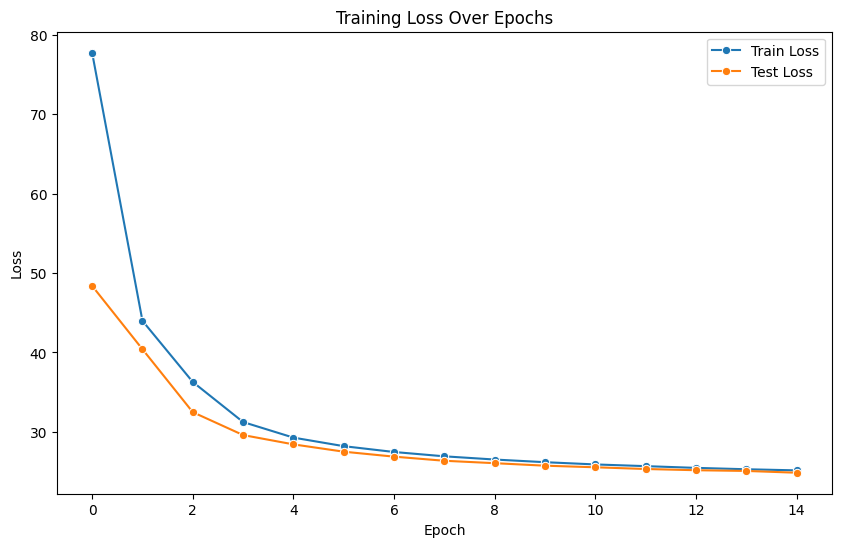

In [ ]:
# Plotting code

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################
import seaborn as sns
#plot:
#The total loss curves for train and test (on the same plot)

plt.figure(figsize=(10, 6))

# Plot the first line
sns.lineplot(x=range(epochs), y=train_loss, marker="o", linestyle="-", label="Train Loss")

# Plot the second line
sns.lineplot(x=range(epochs), y=test_loss, marker="o", linestyle="-", label="Test Loss")

plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Show legend with labels
plt.show()

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

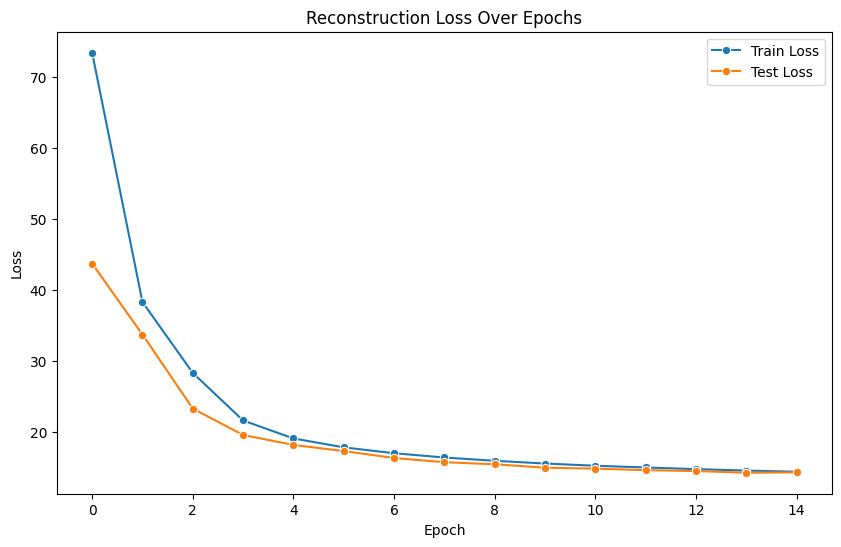

In [ ]:

plt.figure(figsize=(10, 6))

# Plot the first line
sns.lineplot(x=range(epochs), y=train_rec_loss, marker="o", linestyle="-", label="Train Loss")

# Plot the second line
sns.lineplot(x=range(epochs), y=test_rec_loss, marker="o", linestyle="-", label="Test Loss")

plt.title("Reconstruction Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Show legend with labels
plt.show()


#The KL losses for train and test (on the same plot)

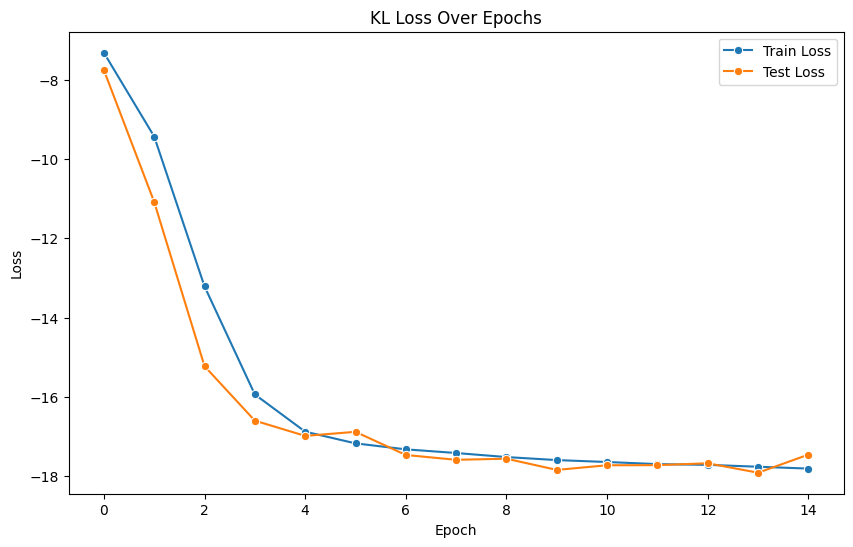

In [ ]:

plt.figure(figsize=(10, 6))

# Plot the first line
sns.lineplot(x=range(epochs), y=train_KL, marker="o", linestyle="-", label="Train Loss")

# Plot the second line
sns.lineplot(x=range(epochs), y=test_KL, marker="o", linestyle="-", label="Test Loss")

plt.title("KL Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Show legend with labels
plt.show()


#The KL losses for train and test (on the same plot)

## Plot loss (3 points)

Analyze and discuss:

1.   Loss curves (reconstruction and KL divergence)
2.   Explain how different values of $\beta$ affect your training.

<font color='red'>***YOUR ANSWER***</font>

1. The reconstruction loss follows the full loss curve closely, with the training loss being higher initially than the test loss but with the loss converging in the final epochs. The train KL loss is also higher than the KL test loss, however in contrast it initially decreases much slower than the reconstruction loss with the test loss increasing slightly in some epochs before evening out and converging with the train loss.
2. Higher $\beta$ values give more importance to the KL divergence term than the reconstruction term in our loss, therefore the model learns to regularize the latent prior than on fitting the input data. A higher $\beta$ value therefore causes the reconstruction loss to graph as a flat line instead of a curve. A lower $\beta$ value gives more priority to the reconstruction loss, which leads the model to focus more on minimising the loss between the reconstruction and input image instead of aiming to conform to the Gaussian distribution of our latent prior.




## Sample and reconstruction quality (6 points)
Simply run the below cell to show the output

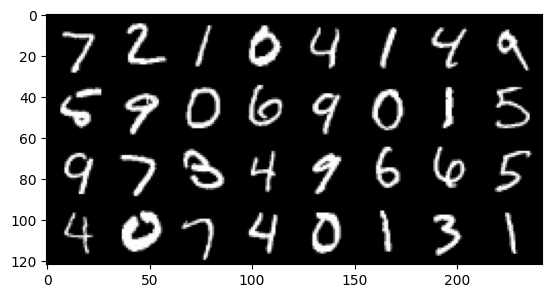

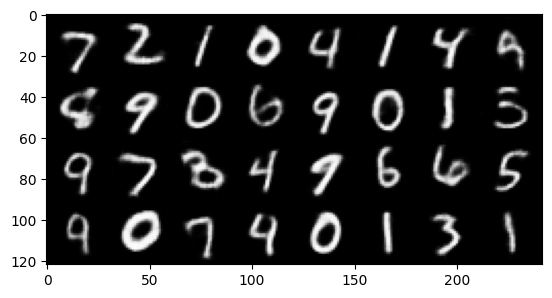

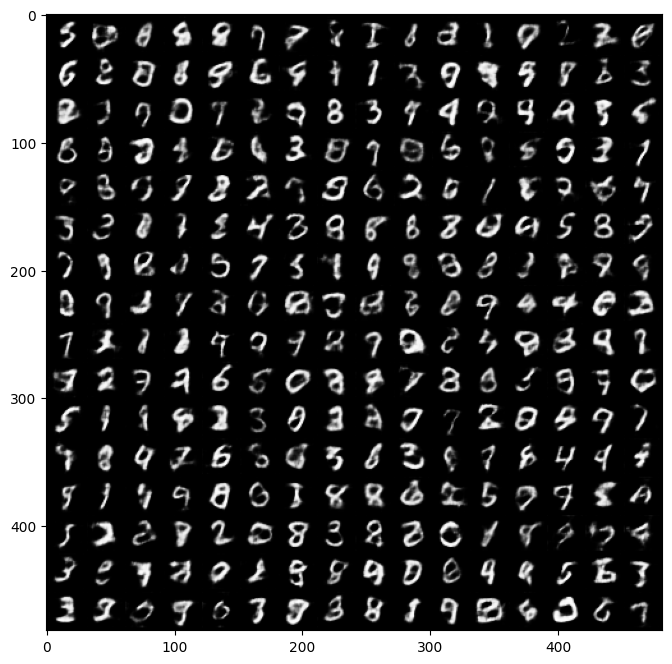

In [ ]:
# Input images
model.eval()
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

# Reconstructed images
with torch.no_grad():

    _, _, recon_batch = model(sample_inputs.to(device))
    recon_batch = recon_batch.unsqueeze(1).reshape(-1,1,28,28)
    recon_batch = recon_batch[0:32, :, :, :]
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denormalize(recon_batch), nrow=8, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

# Generated Images
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():

    samples = model.decode(z)
    samples = samples.unsqueeze(1).reshape(-1,1,28,28)
    samples = samples.cpu()
    samples = make_grid(denormalize(samples), nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## Reconstruction and generated samples discussion (5 points)
Analyze and briefly discuss:

1.   Reconstruction quality
2.   Generated samples quality

Explain in your answers how they relate to different values of $\beta$, latent dimension and VAE architecture

<font color='red'>***YOUR ANSWER***</font>

1.   The reconstruction quality shows that the model has a hard time recreating the number 4 as it confuses it with a number 9, and the reconstructions themselves do not look as sharp as the original input image.
This could be caused to due to the beta, which at 0.7 gives a good priority to the KL divergence term in the loss that has the model attempt to have the reconstructions conform to our Gaussian Distribution latent prior.
2.   The generated samples do not recreate many clear numbers as they appear in our dataset, with some numbers such as 3 and 9 being recreated clearly but others, such as 8 or 6, not being able to be seen as clearly.
The model samples are also sometimes too light to be able to distinguish what number it is trying to recreate in its samples. It is possible that the extra addition of transposed convolutional layer with 64 input and output channels in the decoderis causing some issues with the reconstruction and sample creation of the VAE.

## T-SNE on Embeddings (5 points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

Run the below cells (no coding required).

Qualitatively assess the learned representations of your model using the T-SNE plots.


In [ ]:
alt.data_transformers.disable_max_rows()

def plot_tsne(tsne_xy, dataloader, num_points=1000):

    images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in dataloader.dataset])

    num_points = min(num_points, len(labels))
    data = pd.DataFrame({'x':tsne_xy[:, 0], 'y':tsne_xy[:, 1], 'label':labels,
                        'image': images})
    data = data.sample(n=num_points, replace=False)

    alt.renderers.set_embed_options('light')
    selection = alt.selection_single(on='mouseover', clear='false', nearest=True,
                                    init={'x':data['x'][data.index[0]], 'y':data['y'][data.index[0]]})
    scatter = alt.Chart(data).mark_circle().encode(
        alt.X('x:N',axis=None),
        alt.Y('y:N',axis=None),
        color=alt.condition(selection,
                            alt.value('lightgray'),
                            alt.Color('label:N')),
        size=alt.value(100),
        tooltip='label:N'
    ).add_selection(
        selection
    ).properties(
        width=400,
        height=400
    )

    digit  = alt.Chart(data).transform_filter(
        selection
    ).transform_window(
        index='count()'           # number each of the images
    ).transform_flatten(
        ['image']                 # extract rows from each image
    ).transform_window(
        row='count()',            # number the rows...
        groupby=['index']         # ...within each image
    ).transform_flatten(
        ['image']                 # extract the values from each row
    ).transform_window(
        column='count()',         # number the columns...
        groupby=['index', 'row']  # ...within each row & image
    ).mark_rect(stroke='black',strokeWidth=0).encode(
        alt.X('column:O', axis=None),
        alt.Y('row:O', axis=None),
        alt.Color('image:Q',sort='descending',
            scale=alt.Scale(scheme=alt.SchemeParams('lightgreyteal',
                            extent=[1, 0]),

            ),
            legend=None
        ),
    ).properties(
        width=400,
        height=400,
    )

    return scatter | digit

In [ ]:
# TSNE
from sklearn.manifold import TSNE

for t, (x, y) in enumerate(test_dataloader):
    if t == 0:
        data = x
        labels = y
    else:
        data = torch.cat((data, x))
        labels = torch.cat((labels, y))

# Then let's apply dimensionality reduction with the trained encoder

with torch.no_grad():
    data = data.to(device)
    mu, logvar = model.encode(data)
    z = (model.reparametrize(mu, logvar)).cpu().detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)

In [ ]:
plot_tsne(z_embedded, test_dataloader, num_points=1000)

alt.HConcatChart(...)

### Discussion
Analyze and discuss the visualized T-SNE representations

1. What role do the KL loss term and $\beta$ have?
2. Can you find any outliers?

<font color='red'>***YOUR ANSWER***</font>

The representations show that the model clearly distinguishes some numbers, however it struggles to differentiate between the numbers 4, 9 and 7. We can see the three of the sections pertaining to those numbers intertwined, with 7 being more distinctly separate compared to the 4 and 9. The numbers 1, 2, 0 and 8 seem to perform best.

1. The KL loss term and $\beta$ term are interlinked, as the $\beta$ value is what determines the importance of the KL loss compared to the reconstruction loss. The KL loss attempts to ensure the model follows the latent prior, in this case assumed to be a Gaussian Distribution, instead of recreating the original input image. The beta is the way we can give more or less importance to both, and helps us find a good balance between each one.
2.   Yes, there are a few. We can see visually that some of the numbers are not clearly the number they are tagged as. For example, a number 7 with a very small upper horizontal line that makes it seem visually like a 1 or a 9 with such a large upper loop and small end that it appears visually even to the human eye as a 0. Others are a 4 with a loop, causing it to be labelled as a 2.